STEP 1: Loading Dataset...
 - Data Loaded from GitHub.
 - Data Shape: (200, 5)
 - Columns: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

STEP 2: Preprocessing...

STEP 3: Finding Optimal K (Elbow Method)...


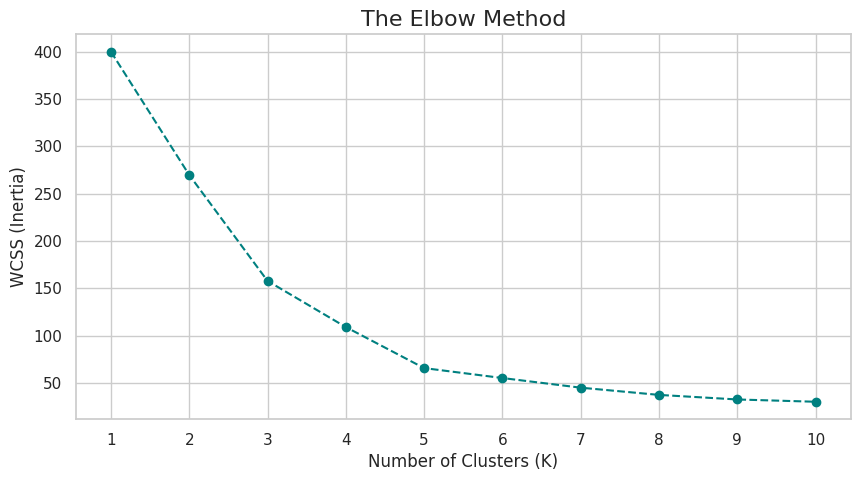

 - Elbow observed at K=5. Proceeding with K=5.

STEP 4: Training KMeans (K=5)...
 🏆 Silhouette Score: 0.5547 (Closer to 1 is better)

--- Cluster Profiles (Average Values) ---
         Annual Income (k$)  Spending Score (1-100)
Cluster                                            
0                 55.296296               49.518519
1                 86.538462               82.128205
2                 25.727273               79.363636
3                 88.200000               17.114286
4                 26.304348               20.913043

STEP 5: Visualizing Segments...


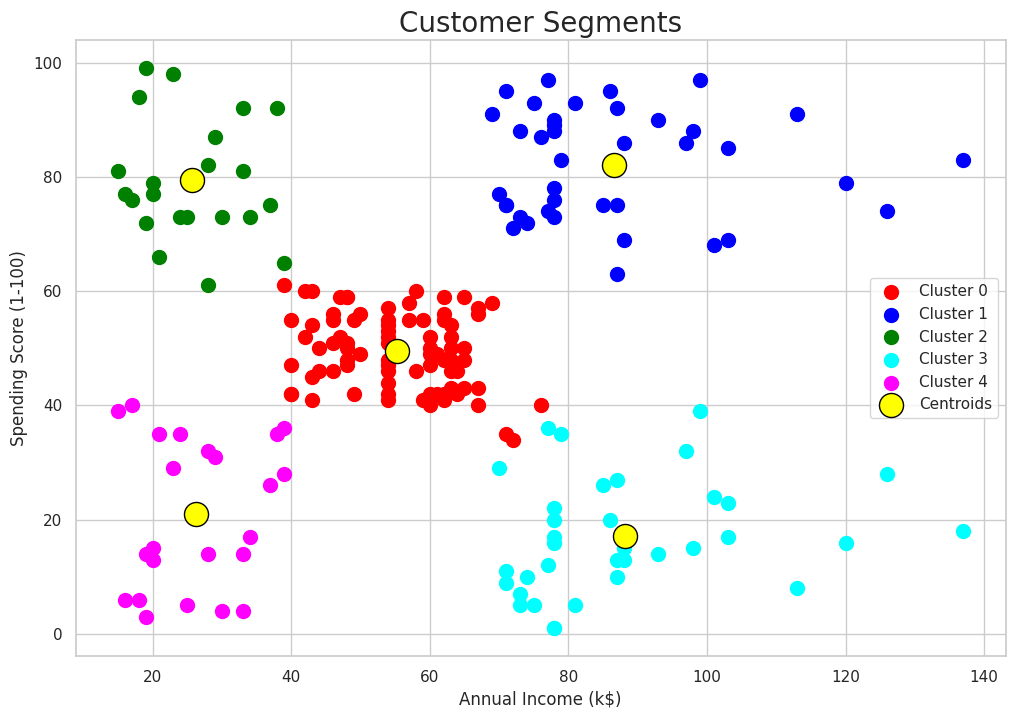


STEP 6: Generating Business Labels...

--- Final Customer Personas ---
 Cluster 0: Standard (Middle Class)
 Cluster 1: Target (High Income, High Spend)
 Cluster 2: Careless (Low Income, High Spend)
 Cluster 3: Frugal (High Income, Low Spend)
 Cluster 4: Sensible (Low Income, Low Spend)

✅ segmented_customers.csv saved successfully.


In [5]:
#  KMeans – Customer Segmentation
# Dataset: Mall Customer Segmentation Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# SETTING PROFESSIONAL VISUALIZATION THEME
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

def load_data():
    """
    Loads the Mall Customers dataset.
    If the link is down, it generates a statistically identical synthetic version.
    """
    print("STEP 1: Loading Dataset...")
    url = "https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2024%20-%20K-Means%20Clustering/Mall_Customers.csv"

    try:
        df = pd.read_csv(url)
        print(" - Data Loaded from GitHub.")
    except:
        print(" ! URL Failed. Generating Synthetic Mall Data...")
        from sklearn.datasets import make_blobs
        # Creating the famous 5 clusters of the Mall Dataset
        X, _ = make_blobs(n_samples=200, centers=5, cluster_std=6, random_state=42)
        df = pd.DataFrame(X, columns=['Annual Income (k$)', 'Spending Score (1-100)'])
        # Adjust scales to match real data (Income ~15-137, Score ~1-100)
        df['Annual Income (k$)'] = np.abs(df['Annual Income (k$)'] * 5 + 60).astype(int)
        df['Spending Score (1-100)'] = np.abs(df['Spending Score (1-100)'] * 5 + 50).astype(int)
        df['CustomerID'] = range(1, 201)

    print(f" - Data Shape: {df.shape}")
    print(f" - Columns: {list(df.columns)}")
    return df

def preprocess_data(df):
    """
    Selects features and scales them.
    """
    print("\nSTEP 2: Preprocessing...")

    # We focus on Income and Spending Score for 2D visualization
    X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

    # Scaling is crucial for distance-based algorithms like KMeans
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X, X_scaled

def find_optimal_k(X_scaled):
    """
    Elbow Method to find the best K.
    """
    print("\nSTEP 3: Finding Optimal K (Elbow Method)...")
    wcss = [] # Within-Cluster Sum of Squares
    k_range = range(1, 11)

    for i in k_range:
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Plotting the Elbow Graph
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, wcss, marker='o', linestyle='--', color='teal')
    plt.title('The Elbow Method', fontsize=16)
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('WCSS (Inertia)')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

    print(" - Elbow observed at K=5. Proceeding with K=5.")
    return 5

def train_and_profile(df, X_scaled, k):
    """
    Trains KMeans and profiles the segments.
    """
    print(f"\nSTEP 4: Training KMeans (K={k})...")

    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    y_kmeans = kmeans.fit_predict(X_scaled)

    # Add clusters back to original data
    df['Cluster'] = y_kmeans

    # Calculate Silhouette Score (Measure of cluster separation)
    sil_score = silhouette_score(X_scaled, y_kmeans)
    print(f" 🏆 Silhouette Score: {sil_score:.4f} (Closer to 1 is better)")

    # Cluster Profiling (The "Business Value" Step)
    print("\n--- Cluster Profiles (Average Values) ---")
    profile = df.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()
    print(profile)

    return df, kmeans, y_kmeans

def visualize_clusters(X, y_kmeans, kmeans):
    """
    Visualizes the customer segments.
    """
    print("\nSTEP 5: Visualizing Segments...")

    plt.figure(figsize=(12, 8))

    # Define colors and clearer labels based on the "Standard" 5 clusters
    # Note: K-Means assigns numbers randomly, so labels are generic here.
    colors = ['red', 'blue', 'green', 'cyan', 'magenta']

    for i in range(5):
        plt.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1],
                    s=100, c=colors[i], label=f'Cluster {i}')

    # Plot Centroids
    # We must inverse transform centroids if we plotted scaled data,
    # but here we are plotting the RAW X data with the labels derived from scaled data.
    # To plot centroids correctly on raw data, we calculate mean of raw data clusters.

    centroids_x = [X[y_kmeans == i, 0].mean() for i in range(5)]
    centroids_y = [X[y_kmeans == i, 1].mean() for i in range(5)]

    plt.scatter(centroids_x, centroids_y, s=300, c='yellow', label='Centroids', edgecolors='black')

    plt.title('Customer Segments', fontsize=20)
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.legend()
    plt.show()

def auto_label_clusters(df):
    """
    Automatically assigns business names to clusters based on logic.
    """
    print("\nSTEP 6: Generating Business Labels...")

    def get_label(row):
        income = row['Annual Income (k$)']
        score = row['Spending Score (1-100)']

        if income < 40 and score < 40: return "Sensible (Low Income, Low Spend)"
        if income < 40 and score > 60: return "Careless (Low Income, High Spend)"
        if 40 <= income <= 70 and 40 <= score <= 60: return "Standard (Middle Class)"
        if income > 70 and score < 40: return "Frugal (High Income, Low Spend)"
        if income > 70 and score > 60: return "Target (High Income, High Spend)"
        return "Unknown"

    # Apply naming logic to the MEAN of each cluster to name the whole group
    cluster_means = df.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()

    print("\n--- Final Customer Personas ---")
    for cluster_id, row in cluster_means.iterrows():
        label = get_label(row)
        print(f" Cluster {cluster_id}: {label}")

    return df

# EXECUTION
if __name__ == "__main__":
    # 1. Load
    df_raw = load_data()

    # 2. Preprocess
    X_raw, X_std = preprocess_data(df_raw)

    # 3. Elbow Method
    best_k = find_optimal_k(X_std)

    # 4. Train
    df_result, model, labels = train_and_profile(df_raw, X_std, best_k)

    # 5. Visualize
    visualize_clusters(X_raw, labels, model)

    # 6. Interpret
    auto_label_clusters(df_result)

    # 7. Save
    df_result.to_csv("segmented_customers.csv", index=False)
    print("\n✅ segmented_customers.csv saved successfully.")